This notebook generates a single batch of experiment 2 under the generative model. Note that theses simulations will not exactly match the simulations in the paper, as they were drawn from a larger, boostrapped, sample.

In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment2 import gen_task_param
sns.set_context('paper', font_scale=1.5)

In [2]:
n_sims = 114

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = -0.5
alpha_scale = 1.0

inv_temp = 10.0
goal_prior = 1e-10 
mapping_prior = 1e-10
pruning_threshold = 500.0
evaluate = False

np.random.seed(0)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None', flat=False, meta=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior, mapping_prior=mapping_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior, mapping_prior=mapping_prior)
            
        if meta:
            p = np.random.uniform(0, 1)
            agent_kwargs['mix_biases'] = [np.log(p), np.log(1-p)]
            agent_kwargs['update_new_c_only'] = True

        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, pruning_threshold=pruning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [14]:
np.random.seed(0)
results_jc = sim_agent(JointClusteringAgent, name='Joint')
# results_ic = sim_agent(IndependentClusterAgent, name='Independent')
# results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
# results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

100%|██████████| 114/114 [05:11<00:00,  2.73s/it]
/anaconda3/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Model Predictions
Summary Statistics:

In [15]:
results['Training'] = results.Context < 7
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  In Goal  Ind Weight  Ind dWeight  Iteration  \
Training Model                                                               
False    Flat          8.5000     True         NaN          NaN       56.5   
         Independent   8.5000     True         NaN          NaN       56.5   
         Joint         8.5000     True         NaN          NaN       56.5   
         Meta          8.5000     True  -12.089935    -1.570457       56.5   
True     Flat          3.8125     True         NaN          NaN       56.5   
         Independent   3.8125     True         NaN          NaN       56.5   
         Joint         3.8125     True         NaN          NaN       56.5   
         Meta          3.8125     True   -6.353758    -0.766140       56.5   

                      Joint Probability  Joint Weight  Joint dWeight  \
Training Model                                                         
False    Flat                       NaN           NaN            NaN   
         Independent                NaN           NaN            NaN   
         Joint                      NaN           NaN            NaN   
         Meta                  0.339115    -14.669324      -1.777006   
True     Flat                       NaN           NaN            NaN   
         Independent                NaN           NaN            NaN   
         Joint                      NaN           NaN            NaN   
         Meta                  0.366803     -8.099064      -1.090937   

                      Key-press    Reward  Steps Taken  Times Seen Context  \
Training Model                                                               
False    Flat          3.478801  0.714912     7.422880               3.500   
         Independent   3.491594  0.657164     5.090278               3.500   
         Joint         3.508406  0.638158     6.010599               3.500   
         Meta          3.480263  0.654240     5.432018               3.500   
True     Flat          3.491228  0.927193     5.389309              14.875   
         Independent   3.496985  0.877741     4.951206              14.875   
         Joint         3.491118  0.898355     5.137610              14.875   
         Meta          3.506579  0.881908     5.032895              14.875   

                      Trial Number       Acc  
Training Model                                
False    Flat                171.5  0.714912  
         Independent         171.5  0.657164  
         Joint               171.5  0.638158  
         Meta                171.5  0.654240  
True     Flat                 79.5  0.927193  
         Independent          79.5  0.877741  
         Joint                79.5  0.898355  
         Meta                 79.5  0.881908

In [16]:
from scipy.stats import ttest_ind

g = results[results['In Goal']].groupby(['Training', 'Model', 'Iteration']).mean()
# g.reset_index(inplace=True)


def print_model_norm(model):
    t, p = ttest_ind(g.loc[(True, 'Flat'),'Acc'], g.loc[(True, model),'Acc'])
    df = len(g.loc[(True, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(True, model),'Acc'].mean() - g.loc[(True,'Flat'),'Acc'].mean()
    print "%s (Train):  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)
    
    t, p = ttest_ind(g.loc[(False, 'Flat'),'Acc'], g.loc[(False, model),'Acc'])
    df = len(g.loc[(False, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(False, model),'Acc'].mean() - g.loc[(False,'Flat'),'Acc'].mean()
    print "%s (Test) :  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)

print_model_norm('Independent')
print_model_norm('Joint')
print_model_norm('Meta')


Independent (Train):  M=-0.0495, t(226)=6.7719, p=1.09e-10
Independent (Test) :  M=-0.0577, t(226)=3.6881, p=0.000283
Joint (Train):  M=-0.0288, t(226)=5.5411, p=8.33e-08
Joint (Test) :  M=-0.0768, t(226)=4.8957, p=1.86e-06
Meta (Train):  M=-0.0453, t(226)=7.268, p=5.89e-12
Meta (Test) :  M=-0.0607, t(226)=4.1697, p=4.35e-05


Plot the overall rewards collected in the training and test contexts

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


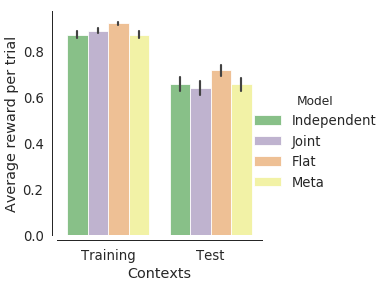

In [17]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 6, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 7, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


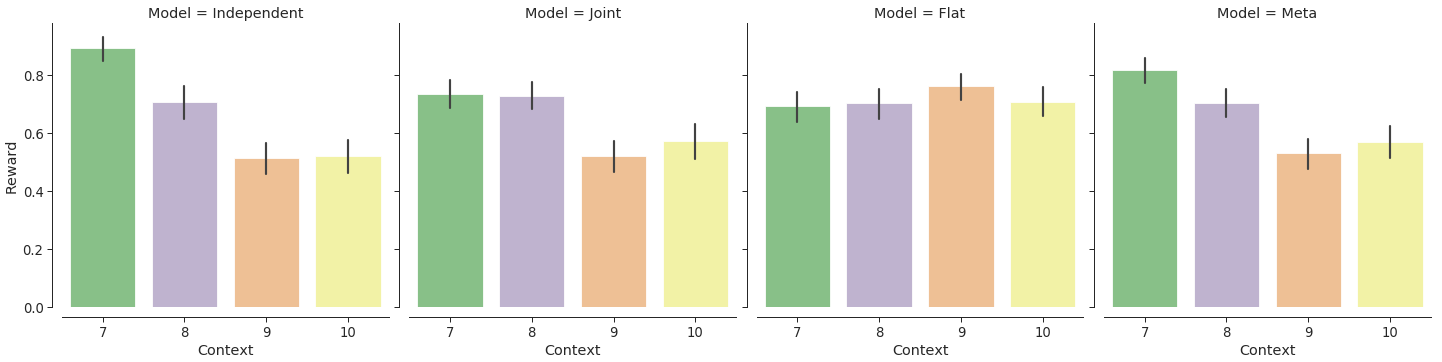

In [18]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Accent', col='Model', units='Iteration')
    g.set_xlabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

In [19]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context >= 7) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
            
        a = (subj_df.Context == 7)
        b = (subj_df.Context == 8) | (subj_df.Context == 10)
        diff_1 = subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

        a = (subj_df.Context == 7) | (subj_df.Context == 8)
        b = (subj_df.Context == 9) | (subj_df.Context == 10)
        diff_2 =subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

        a = (subj_df.Context == 9)
        b = (subj_df.Context == 10)
        diff_3 = \
            subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1


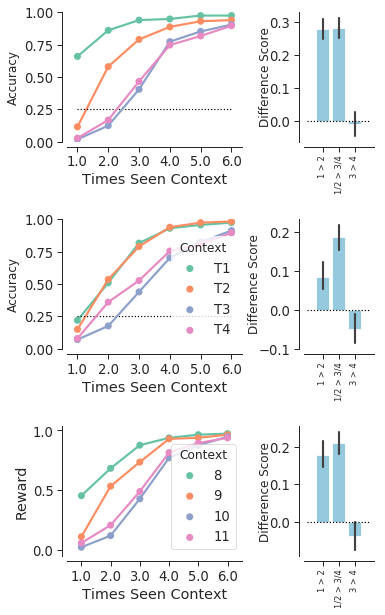

In [20]:


with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 10.))
    gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])],
        [plt.subplot(gs[4]),  plt.subplot(gs[5])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Meta'],  palette='Set2', ax=axes[2][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    
    
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    sns.barplot(x='Comparison', y='Difference Score',
            data=score[score.Model == 'Meta'], color='skyblue', ax=axes[2][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1, 2]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
        
#     plt.savefig('Exp2_fig1.png', dpi=300)

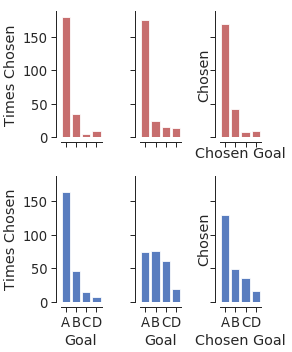

In [21]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cmap = "BrBG"
n = 3
# cc = [sns.color_palette(cmap, n_colors=16)[n], sns.color_palette(cmap, n_colors=16)[-(1+n)]]
cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(4, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=axes[0][0],
                color=cc[3])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=axes[1][0],
                color=cc[0]) 
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=axes[0][1], color=cc[3])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=axes[1][1], color=cc[0]) 
    
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 2)], ax=axes[0][2],
                color=cc[3])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 1)], ax=axes[1][2],
                color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel('Times Chosen')
        
        ax = axes[ii][1]
        ax.set_ylabel('')

        ax = axes[1][ii]
        ax.set_xlabel('Goal')

        ax = axes[0][ii]
        ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()


In [22]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cc = sns.color_palette('muted')
df0['Chosen'] = [1] * len(df0)

In [23]:
#within subject errorbars (standard error)
df0 = results[results['In Goal'] & (results.Context > 6)
             & (results['Model'] != 'Flat')].copy()


cc = sns.color_palette('Set2')
def plot_test_context(m, c, ax, color, label):
    ctx = df0.loc[(df0['Times Seen Context'] < 6) & (df0['Context'] == c) & 
                  (df0['Model'] == m), 'Reward'
                ].values.reshape(n_sims, -1)
    ctx_std_err = np.array(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T +\
                           np.tile(ctx.mean(), np.shape(ctx)),dtype='float').std(axis=0) \
                    / np.sqrt(n_sims)

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=3)
    
from scipy.stats import ttest_1samp
def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) & (diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values)
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)
    
def plot_model_test_context(model):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(3,3))
        plot_test_context(model, 7, ax, cc[0], 'T1')
        plot_test_context(model, 8, ax, cc[1], 'T2')
        plot_test_context(model, 9, ax, cc[2], 'T3')
        plot_test_context(model, 10, ax, cc[3], 'T4')
        legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
        legend.get_frame().set_edgecolor('w')
        ax.get_legend().get_title().set_fontsize(12)
        ax.set_xticks(range(1, 6))
        ax.set_xlabel('Times Seen Context', fontsize=15)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.plot([1, 5], [1./4, 1./4], 'k:')
        ax.set_ylim([0, 1])
        plt.title(model, fontsize=18, fontname='Helvetica')
        sns.despine(offset=5)
        

Plot the model responsibilities over time

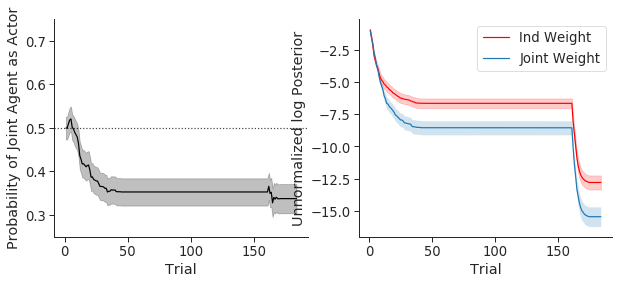

In [24]:
with sns.axes_style('ticks'):

    df0 = results[(results['Steps Taken']==1) & 
                  (results['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
#     plt.savefig('Exp2_fig4.pdf', dpi=300)